In [11]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
from PIL import Image
import requests
import datetime
from io import BytesIO
from tqdm import tqdm

In [18]:
'''

목표 : 자동 매핑이 안된 개체들을 "수동으로" 매핑하자 !
매핑 대상 : mapping=2인 개체들

매핑 프로세스 :
-> kobis 데이터와 celeb 내 동명이인들 데이터를 출력해서 비교
-> 같은 인물인 경우, input에 series_id를 입력하면 매핑이 되고
-> 같은 인물이 아닌 경우, input에 아무것도 입력 x
-> 매핑이 된 개체들은 mapping=1로 업데이트가 되고, kuk.movie_people_connection 에도 자동으로 insert 됨
-> 매핑이 안된 개체들은 mapping=0로 업데이트 되고, 후에 인물등록 진행하면 됨

* 참고
파이참으로 수기매핑하면 사진이 안떠서, 주피터로 매핑하는게 더 편함..!

'''


def db_connection(host_name='ds'):
    host_url = "db.ds.mycelebs.com"
    user_nm = "j_eungg"
    passwd = "mycelebs"
    port_num = 3306
#     db_name = "maimovie_kr"
    conn = pymysql.connect(host=host_url, user=user_nm, passwd=passwd, port = port_num, charset='utf8',
                           cursorclass=pymysql.cursors.DictCursor)
    # cursorclass=pymysql.cursors.DictCursor 추가 -> 데이터프레임으로 다루기 쉽게 딕셔너리 형태로 결과 반환해줌, cursor는 튜플형태
    # db=db,
    engine = create_engine(f'mysql+pymysql://{user_nm}:{passwd}@{host_url}:{port_num}/kuk?charset=utf8mb4')
    return conn, engine


def getPeople():
    conn, engine = db_connection()

    query = "select * from maimovie_kr.kobis_people_list"
    kobis = pd.read_sql(query, con=conn)

    kobis = kobis[(kobis['repRoleNm'] == '배우') | (kobis['repRoleNm'] == '감독') | (kobis['repRoleNm'] == '조감독')]      # 배우, 감독, 조감독인 사람들
    kobis = kobis.drop_duplicates(subset='peopleCd', keep='first')      # 중복 제거
    kobis = kobis.dropna(subset=['profile_naverURL'])       # 네이버 url 있는 사람들

    # 이름 글자 수가 5이상이면 외국인이라고 판단....?
    kobis['nm_num'] = kobis.peopleNm.str.len()      # 이름 글자 수 추출
    kobis = kobis[kobis['nm_num'] <= 4]         # 한국인만 추출

    total_kobis = kobis      # total 매핑 대상

    query_ = "select * from maimovie_kr.kobis_people_list where mapping=2"
    data = pd.read_sql(query_, conn)

    print("[INFO] data load DONE!\n")
    print("[INFO] 수기 매핑해야 하는 개체는 {} 명 입니다.".format(len(data)))
    conn.close()

    return total_kobis, data


# 수기 매핑
def handMapping(number) :
    conn, engine = db_connection()
    
    ex = data.iloc[:number, :]

    idx_ = []
    ex['celeb_idx'] = ''

    for i, row in tqdm(ex.iterrows(), total=ex.shape[0]):

        peopleCode = row['peopleCd']
        name = row['peopleNm']
        gender = row['sex']
        job = row['repRoleNm']
        url = row['profile_naverURL']
        img = row['profileImage']
        url = row['profile_naverURL']

        print("-------- KOBIS 데이터 ----------")
        try:
            kd_response = requests.get(img)
            kd_img = Image.open(BytesIO(kd_response.content))
            display(kd_img)
        except:
            pass

        print("인물코드: ", peopleCode)
        print("이름: ", name, "| 직업: ", job, "| 네이버: ", url)

        query = f'''select *
                from star_ko.star_ko_data
                where (cd_name='{name}' or cd_real_name='{name}')
                    and (cd_category LIKE '%감독%' OR cd_category LIKE '%배우%' OR cd_category LIKE '%방송인%' OR cd_category LIKE '%탤런트%' OR cd_category LIKE '%작가%' OR cd_category LIKE '%PD%' OR cd_category LIKE '%연출%') and cd_is_use=1
                    '''
        celeb = pd.read_sql(query, con=conn)

        for c, crow in celeb.iterrows():
            cd_name = crow['cd_name']
            series_id = crow['series_id']
            cd_category = crow['cd_basic_info']
            cd_gender = crow['cd_gender']
            cd_birth = str(crow['cd_birth'])
            cd_solr_search = crow['cd_solr_search']
            #         cd_agency = crow['cd_agency']
            cd_debut = crow['cd_debut']
            cd_img_url = crow['profile_url_main']


            keywords = ['man', 'woman', 'group']
            result = any(keyword in cd_img_url for keyword in keywords)

            print("---------- 셀럽 데이터 ----------")

            if not result:  # 스타ai에 이미지가 있으면
                print("seires_id: ", series_id)
                try:
                    cd_img_url = crow['profile_url_main']
                    cd_response = requests.get(cd_img_url)
                    cd_img = Image.open(BytesIO(cd_response.content))
                    cd_img = cd_img.resize((120, 150))
                    display(cd_img)
                except:
                    pass

            else:
                pass

            donut = f"http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/{series_id}"
            print("series_id: ", series_id)
            print("이름: ", cd_name, "| 직업: ", cd_category, "| 생일: ", cd_birth[0:-9], "| 솔라쿼리: ", cd_solr_search,
                  "| 데뷔: ", cd_debut, "| 도넛: ", donut)

            idx = input("series_id를 매핑해주세요 : ")
            idx_.append(idx)

            if idx == '':
                print("[INFO] 매핑 실패!\n")
            else:
                ex['celeb_idx'][i] = idx
                print("[INFO] 매핑 완료!\n")

    conn.close()

    return ex



def db_update(ex) :

    conn, engine = db_connection()
    cursor = conn.cursor(pymysql.cursors.DictCursor)

    duplicated_list = []

    ex = ex.rename({'peopleCd': 'kobis_people_id', 'peopleNm': 'cd_name'}, axis=1)

    mapping_data = ex[ex['celeb_idx'] != '']
    newPeople_data = ex[ex['celeb_idx'] == '']

    # 맵핑된 개체들 movie_people_connection db insert
    if len(mapping_data) > 0:
        mapping_df = mapping_data.loc[:, ['kobis_people_id', 'celeb_idx', 'cd_name']]
        # mapping_df = mapping_df.astype({'celeb_idx': 'int'})
        # mapping_df['update_date'] = data_date
        # mapping_df.to_sql('movie_people_connection', engine, if_exists='append', index=None)
        # print("[INFO] 수기 매핑 결과 -> movie_people_connection db insert 완료")

        for i, row in mapping_df.iterrows():
            kobis_people_id = row['kobis_people_id']
            celeb_idx = row['celeb_idx']
            cd_name = row['cd_name']

            qry1 = f'select * from kuk.movie_people_connection where celeb_idx={celeb_idx}'
            result1 = pd.read_sql(qry1, conn)

            if len(result1) == 0:
                qry2 = f'INSERT INTO kuk.movie_people_connection (kobis_people_id, celeb_idx, cd_name, update_date) values ({kobis_people_id}, {celeb_idx}, \'{cd_name}\', NOW())'
                cursor.execute(qry2)
            else:
                duplicated = {'kobis_people_id': kobis_people_id, 'celeb_idx': celeb_idx, 'cd_name': cd_name}
                duplicated_list.append(duplicated)
                print('! 중복된 celeb_idx 가 있습니다. kobis_people_id: {0}, celeb_idx: {1}, cd_name: {2}'.format(kobis_people_id, celeb_idx, cd_name))

        print("[INFO] 1차 매핑 결과 -> movie_people_connection db insert 완료")
        conn.commit()

        # mapping 여부 db update
        mapping_list = mapping_df['kobis_people_id'].to_list()
        mapping_query = "UPDATE maimovie_kr.kobis_people_list SET mapping=1 WHERE peopleCd=%s;"
        cursor.executemany(mapping_query, mapping_list)
        conn.commit()
        print("[INFO] 수기 매핑 결과 -> mapping = 1 db update 완료")

    if len(newPeople_data) > 0:
        not_mapping_list = newPeople_data['kobis_people_id'].to_list()
        not_mapping_query = "UPDATE maimovie_kr.kobis_people_list SET mapping=0 WHERE peopleCd=%s;"
        cursor.executemany(not_mapping_query, not_mapping_list)
        conn.commit()
        print("[INFO] 수기 매핑 결과 -> mapping = 0 db update 완료")

    conn.close()

    return mapping_data, duplicated_list


def report(mapping_data, total_kobis, data) :
    conn, engine = db_connection()

    query = "select COUNT(*) from kuk.movie_people_connection"
    cnt = pd.read_sql(query, con=conn)
    cnt = cnt.iloc[0, 0]

    print('* KOBIS 영화 인물 수기매핑 결과입니다.')
    print('- DB명 : kuk > kobis_people_connection')
    print("수기 매핑 결과 : {0} / {1}".format(len(mapping_data), len(data)))
    print("누적 매핑 개수 : {0} / {1}".format(cnt, len(total_kobis)))

    conn.close()


In [19]:
now = datetime.datetime.now()
data_date = now.strftime('%Y-%m-%d %H:%M:00')

total_kobis, data = getPeople()

[INFO] data load DONE!

[INFO] 수기 매핑해야 하는 개체는 90 명 입니다.


매핑할 개체 수 입력 : 90


<ipython-input-18-bc11b53ff014>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['celeb_idx'] = ''
  0%|          | 0/90 [00:00<?, ?it/s]

-------- KOBIS 데이터 ----------
인물코드:  20163384
이름:  이원일 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9D%B4%EC%9B%90%EC%9D%BC&os=14055686&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  2100


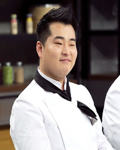

series_id:  2100
이름:  이원일 | 직업:  요리연구가 | 생일:  1979-12-12 | 솔라쿼리:  (content_all:(title: "이원일" AND "셰프") AND type:news) | 데뷔:   | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/2100
series_id를 매핑해주세요 : 


  1%|          | 1/90 [00:05<08:33,  5.77s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20162975
이름:  이대로 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9D%B4%EB%8C%80%EB%A1%9C&os=14084249&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  19127394
이름:  이대로 | 직업:  배우 | 생일:  1939-10-13 | 솔라쿼리:  (content_all:(title:"이대로" AND type:news AND "배우 이대로" AND ("징비록" OR "정도전" OR "칼과 꽃"))) | 데뷔:  1980년 KBS 특채 탤런트 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/19127394
series_id를 매핑해주세요 : 


  2%|▏         | 2/90 [00:30<24:41, 16.83s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20162727
이름:  김진수 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EC%A7%84%EC%88%98&os=14039209&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  2127


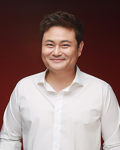

series_id:  2127
이름:  김진수 | 직업:  영화배우, 탤런트 | 생일:  1971-01-25 | 솔라쿼리:  (content_all:("배우 김진수"~10 OR "영화배우 김진수"~10 OR "매니지먼트 구 김진수"~10 OR "탤런트 김진수"~10)) | 데뷔:  1995년 MBC '젊음의 다섯마당' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/2127
series_id를 매핑해주세요 : 


  3%|▎         | 3/90 [00:52<28:06, 19.39s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20161810
이름:  이영자 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9D%B4%EC%98%81%EC%9E%90&os=14040053&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  765


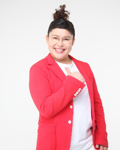

series_id:  765
이름:  이영자 | 직업:  None | 생일:  1968-08-15 | 솔라쿼리:  (content_all:(title:"이영자"  AND "기자" NOT "눈물")) | 데뷔:  1991년 MBC 개그콘테스트 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/765
series_id를 매핑해주세요 : 


  4%|▍         | 4/90 [00:58<19:56, 13.92s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


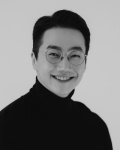

인물코드:  10005597
이름:  김정운 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EC%A0%95%EC%9A%B4&os=171275&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  12504551
이름:  김정운 | 직업:  탤런트 | 생일:  1981-12-03 | 솔라쿼리:  (content_all:(title:"김정운" AND type:news)) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/12504551
series_id를 매핑해주세요 : 12504551


<ipython-input-18-bc11b53ff014>:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['celeb_idx'][i] = idx
<ipython-input-20-8e259c2fa796>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex = handMapping(number)
  6%|▌         | 5/90 [01:55<42:02, 29.68s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------


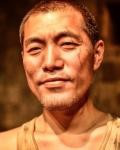

인물코드:  10005977
이름:  김창규 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EC%B0%BD%EA%B7%9C&os=2751224&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1242


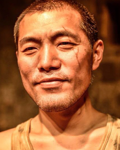

series_id:  1242
이름:  김운하 | 직업:  영화배우 | 생일:  1939-11-25 | 솔라쿼리:  (content_all:("영화배우 김창규"~10 OR "배우 김창규"~10 OR "영화배우 김운하"~10 OR "배우 김운하"~10)) | 데뷔:  1961년 영화 '현해탄은 알고있다' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1242
series_id를 매핑해주세요 : 1242


  7%|▋         | 6/90 [02:05<31:47, 22.71s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------
인물코드:  20160568
이름:  최유리 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%B5%9C%EC%9C%A0%EB%A6%AC&os=14185127&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  11674914
이름:  최유리 | 직업:  탤런트 | 생일:  2009-02-12 | 솔라쿼리:  (content_all:("이태원 클라쓰 최유리"~50 OR "아역배우 최유리"~10 OR "원더풀고스트 최유리"~30 NOT "애스크" NOT "ASK" NOT "홍보대행사" NOT "모다까리나" NOT "안시성")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/11674914
series_id를 매핑해주세요 : 


  8%|▊         | 7/90 [02:27<31:08, 22.51s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20159666
이름:  정재호 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A0%95%EC%9E%AC%ED%98%B8&os=14220757&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  14768943


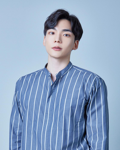

series_id:  14768943
이름:  정재호 | 직업:  방송인 | 생일:  1990-08-11 | 솔라쿼리:  (content_all:(title:"정재호" AND"기자" AND("방송인 정재호"~5 OR "하트 시그널" OR "에스팀") NOT"축구" NOT"대표팀" NOT"교수")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/14768943
series_id를 매핑해주세요 : 


  9%|▉         | 8/90 [02:35<24:27, 17.90s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


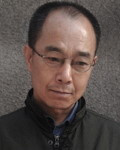

인물코드:  20159631
이름:  최용진 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%B5%9C%EC%9A%A9%EC%A7%84&os=14069654&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  18727821
이름:  최용진 | 직업:  영화배우 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:(title:"최용진" AND type:news AND "배우")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18727821
series_id를 매핑해주세요 : 18727821


 10%|█         | 9/90 [1:16:23<31:25:35, 1396.73s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------


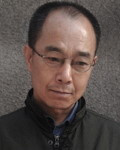

인물코드:  20159628
이름:  최용진 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%B5%9C%EC%9A%A9%EC%A7%84&os=14069654&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  18727821
이름:  최용진 | 직업:  영화배우 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:(title:"최용진" AND type:news AND "배우")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18727821
series_id를 매핑해주세요 : 18727821


 11%|█         | 10/90 [1:16:35<21:32:05, 969.07s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------
인물코드:  20159625
이름:  정재형 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A0%95%EC%9E%AC%ED%98%95&os=14045420&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  887


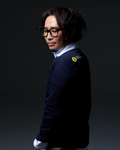

series_id:  887
이름:  정재형 | 직업:  None | 생일:  1970-01-12 | 솔라쿼리:  (content_all: (title : "정재형") AND"기자" AND("가수 정재형" or "방송인 정재형" ) ) | 데뷔:  1995년 베이시스 1집 앨범 'Looking For Myself' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/887
series_id를 매핑해주세요 : 


 12%|█▏        | 11/90 [1:16:44<14:49:11, 675.33s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20159399
이름:  정유진 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A0%95%EC%9C%A0%EC%A7%84&os=14035314&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  281126


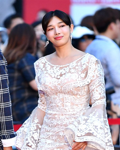

series_id:  281126
이름:  선우선 | 직업:  탤런트, 영화배우 | 생일:  1975-03-21 | 솔라쿼리:  (content_all:("영화배우 sun woo sun"~10 OR "배우 sun woo sun"~10 OR "탤런트 sun woo sun"~10 OR "광윤 인터내셔널 sun woo sun"~10 OR "영화배우 정유진"~10 OR "배우 정유진"~10 OR "탤런트 정유진"~10 OR "광윤 인터내셔널 정유진"~10 OR "영화배우 sun woosun"~10 OR "배우 sun woosun"~10 OR "탤런트 sun woosun"~10 OR "광윤 인터내셔널 sun woosun"~10 OR "영화배우 선우선"~10 OR "배우 선우선"~10 OR "탤런트 선우선"~10 OR "광윤 인터내셔널 선우선"~10 OR "영화배우 선 우선"~10 OR "배우 선 우선"~10 OR "탤런트 선 우선"~10 OR "광윤 인터내셔널 선 우선"~10 OR "영화배우 sunwoosun"~10 OR "배우 sunwoosun"~10 OR "탤런트 sunwoosun"~10 OR "광윤 인터내셔널 sunwoosun"~10)) | 데뷔:  제1회 씨네스타 오디션 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/281126
series_id를 매핑해주세요 : 


 13%|█▎        | 12/90 [1:16:48<10:12:23, 471.08s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20159398
이름:  정유진 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A0%95%EC%9C%A0%EC%A7%84&os=14035314&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  281126


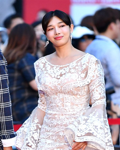

series_id:  281126
이름:  선우선 | 직업:  탤런트, 영화배우 | 생일:  1975-03-21 | 솔라쿼리:  (content_all:("영화배우 sun woo sun"~10 OR "배우 sun woo sun"~10 OR "탤런트 sun woo sun"~10 OR "광윤 인터내셔널 sun woo sun"~10 OR "영화배우 정유진"~10 OR "배우 정유진"~10 OR "탤런트 정유진"~10 OR "광윤 인터내셔널 정유진"~10 OR "영화배우 sun woosun"~10 OR "배우 sun woosun"~10 OR "탤런트 sun woosun"~10 OR "광윤 인터내셔널 sun woosun"~10 OR "영화배우 선우선"~10 OR "배우 선우선"~10 OR "탤런트 선우선"~10 OR "광윤 인터내셔널 선우선"~10 OR "영화배우 선 우선"~10 OR "배우 선 우선"~10 OR "탤런트 선 우선"~10 OR "광윤 인터내셔널 선 우선"~10 OR "영화배우 sunwoosun"~10 OR "배우 sunwoosun"~10 OR "탤런트 sunwoosun"~10 OR "광윤 인터내셔널 sunwoosun"~10)) | 데뷔:  제1회 씨네스타 오디션 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/281126
series_id를 매핑해주세요 : 


 14%|█▍        | 13/90 [1:17:05<7:08:12, 333.67s/it] 

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20158960
이름:  박연수 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%95%EC%97%B0%EC%88%98&os=14111282&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  3297


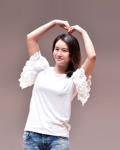

series_id:  3297
이름:  박잎선 | 직업:  탤런트, 영화배우 | 생일:  1979-04-05 | 솔라쿼리:  (content_all:((title:"박연수" -title:"송종국" -title:"송지아" -title:"송지욱") AND type:news)) | 데뷔:  2001년 영화 '눈물' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/3297
series_id를 매핑해주세요 : 
[INFO] 매핑 실패!

---------- 셀럽 데이터 ----------
seires_id:  9560695


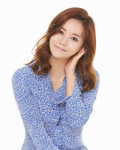

series_id:  9560695
이름:  박연수 | 직업:  영화배우 | 생일:  1979-04-05 | 솔라쿼리:  (content_all:((title:"박연수" -title:"송지아" -title:"딸" -title:"송지욱" -title:"아들") AND"기자" NOT"리틀수지" NOT"박영선" NOT"정주천" NOT"토니")) | 데뷔:  2001년 영화 '눈물' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/9560695
series_id를 매핑해주세요 : 


 16%|█▌        | 14/90 [1:17:32<5:05:08, 240.90s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20158550
이름:  박소현 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%95%EC%86%8C%ED%98%84&os=14037166&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  348


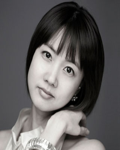

series_id:  348
이름:  박소현 | 직업:  None | 생일:   | 솔라쿼리:  (content_all:(title:"박소현"AND "기자" AND ("탤런트 박소현"~5 OR "방송인 박소현"~5 OR "박소현의 러브게임"))) | 데뷔:  1993년 SBS '출발 서울의 아침' 리포터 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/348
series_id를 매핑해주세요 : 


 17%|█▋        | 15/90 [1:17:39<3:32:52, 170.30s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20158298
이름:  정세진 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A0%95%EC%84%B8%EC%A7%84&os=14098613&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1865


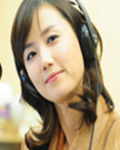

series_id:  1865
이름:  정세진 | 직업:  아나운서, 앵커 | 생일:  1973-06-25 | 솔라쿼리:  (content_all:(title:"정세진" AND type:news AND ("정세진 아나운서"~10 OR "정세진 앵커"~10))) | 데뷔:  1997년 KBS 24기 공채 아나운서 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1865
series_id를 매핑해주세요 : 


 18%|█▊        | 16/90 [1:17:41<2:27:32, 119.63s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20158161
이름:  오유경 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%98%A4%EC%9C%A0%EA%B2%BD&os=18124641&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1612


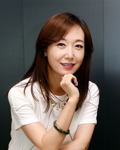

series_id:  1612
이름:  오유경 | 직업:  아나운서 | 생일:   | 솔라쿼리:  (content_all:(title:"오유경" AND type:news AND "아나운서 오유경"~10)) | 데뷔:  1994년 KBS 20기 공채 아나운서 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1612
series_id를 매핑해주세요 : 


 19%|█▉        | 17/90 [1:17:54<1:46:47, 87.77s/it] 

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20158042
이름:  오아름 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%98%A4%EC%95%84%EB%A6%84&os=14097653&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1611


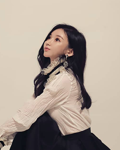

series_id:  1611
이름:  오아름 | 직업:  방송인, 가수 | 생일:  1991-05-31 | 솔라쿼리:  (content_all:(title:"오아름" AND type:news AND ("가수 오아름"~10 OR "방송인 오아름"~10))) | 데뷔:   | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1611
series_id를 매핑해주세요 : 


 20%|██        | 18/90 [1:18:27<1:25:26, 71.20s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20157421
이름:  최승연 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%B5%9C%EC%8A%B9%EC%97%B0&os=14056018&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  18524172
이름:  최승연 | 직업:  가수,뮤지컬배우 | 생일:  1990-12-31 | 솔라쿼리:  (content_all:(title:"최승연" AND("가수" OR "뮤지컬"))) | 데뷔:  2021년 싱글 앨범 [있을까] | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18524172
series_id를 매핑해주세요 : 


 21%|██        | 19/90 [1:18:43<1:04:48, 54.76s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20156968
이름:  최수영 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%B5%9C%EC%88%98%EC%98%81&os=14031106&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  529


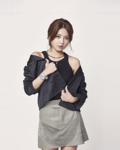

series_id:  529
이름:  수영 | 직업:  None | 생일:  1990-02-10 | 솔라쿼리:  (content_all:((title:"수영" title:"최수영")AND"기자" AND("가수 수영"~5 OR "배우 수영"~5 OR "배우 최수영"~5 OR "소녀시대") NOT"류수영")) | 데뷔:  2002년 Route O 싱글 앨범 'START' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/529
series_id를 매핑해주세요 : 


 22%|██▏       | 20/90 [1:18:52<47:53, 41.04s/it]  

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20156697
이름:  박설희 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%95%EC%84%A4%ED%9D%AC&os=16057435&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  12396629
이름:  한지완 | 직업:  탤런트 | 생일:  1987-08-14 | 솔라쿼리:  (content_all:("루갈 한지완"~50 OR "탤런트 한지완"~10 OR "WWW 한지완"~50)) | 데뷔:  2012년 MBC 드라마 '아이두 아이두' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/12396629
series_id를 매핑해주세요 : 


 23%|██▎       | 21/90 [1:19:42<50:11, 43.64s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20156359
이름:  정영준 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A0%95%EC%98%81%EC%A4%80&os=18168490&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  7600996


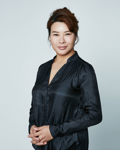

series_id:  7600996
이름:  정영주 | 직업:  뮤지컬배우 | 생일:  1971-05-23 | 솔라쿼리:  (content_all:("정영주" OR "배우 정영주"~5)) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/7600996
series_id를 매핑해주세요 : 


 24%|██▍       | 22/90 [1:19:54<38:37, 34.08s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20156231
이름:  윤지수 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9C%A4%EC%A7%80%EC%88%98&os=14151745&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  18955920
이름:  윤지수 | 직업:  연극배우 | 생일:  1994-05-03 | 솔라쿼리:  (content_all:(title:"윤지수" AND type:news AND("경험과 상상" OR "연극") NOT"박규영")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18955920
series_id를 매핑해주세요 : 


 26%|██▌       | 23/90 [1:20:13<33:08, 29.69s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


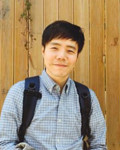

인물코드:  20156084
이름:  임성용 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9E%84%EC%84%B1%EC%9A%A9&os=14064008&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  18712597
이름:  임성용 | 직업:  영화감독 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:(title:"임성용" AND type:news AND "감독")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18712597
series_id를 매핑해주세요 : 18712597


 27%|██▋       | 24/90 [1:20:30<28:16, 25.71s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------
인물코드:  20155212
이름:  이성덕 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9D%B4%EC%84%B1%EB%8D%95&os=14040715&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  3224


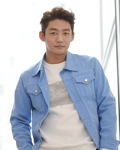

series_id:  3224
이름:  이태성 | 직업:  영화배우, 탤런트 | 생일:  1985-04-21 | 솔라쿼리:  (content_all:(title:"이태성" AND type:news AND "배우 이태성"~10)) | 데뷔:   | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/3224
series_id를 매핑해주세요 : 


 28%|██▊       | 25/90 [1:20:43<23:51, 22.02s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


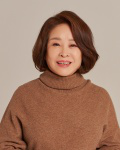

인물코드:  20155141
이름:  전성애 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A0%84%EC%84%B1%EC%95%A0&os=189377&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  15747379


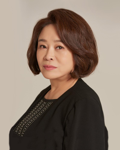

series_id:  15747379
이름:  전성애 | 직업:  영화배우 | 생일:  1956-03-29 | 솔라쿼리:  (content_all:("전성애" NOT"공주" NOT"넥타이를" NOT"콘테스트")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/15747379
series_id를 매핑해주세요 : 15747379


 29%|██▉       | 26/90 [1:20:54<19:45, 18.52s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------


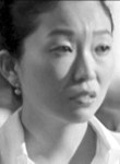

인물코드:  20155084
이름:  이선정 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9D%B4%EC%84%A0%EC%A0%95&os=14158749&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  163379


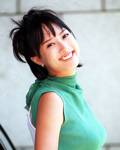

series_id:  163379
이름:  이선정 | 직업:  탤런트, 영화배우 | 생일:  1978-01-10 | 솔라쿼리:  (content_all:(title:"이선정" AND type:news )) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/163379
series_id를 매핑해주세요 : 


 30%|███       | 27/90 [1:21:29<24:42, 23.53s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20155016
이름:  장선영 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9E%A5%EC%84%A0%EC%98%81&os=14091036&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  290669


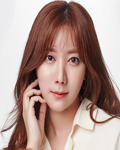

series_id:  290669
이름:  장다윤 | 직업:  탤런트 | 생일:  1991-01-22 | 솔라쿼리:  (content_all:("장다윤")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/290669
series_id를 매핑해주세요 : 


 31%|███       | 28/90 [1:21:35<19:00, 18.39s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


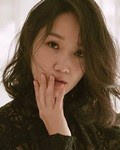

인물코드:  20154813
이름:  박보경 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%95%EB%B3%B4%EA%B2%BD&os=10007191&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  18989349
이름:  박보경 | 직업:  영화배우,연극배우 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:(title:"박보경" AND type:news AND "배우")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18989349
series_id를 매핑해주세요 : 18989349


 32%|███▏      | 29/90 [1:21:48<16:54, 16.63s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------
인물코드:  10072322
이름:  최선아 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%B5%9C%EC%84%A0%EC%95%84&os=165539&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  19083216
이름:  김도은 | 직업:  연극배우 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:(title:"김도은" AND type:news AND "배우" NOT "슈퍼탤런트")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/19083216
series_id를 매핑해주세요 : 


 33%|███▎      | 30/90 [1:22:08<17:45, 17.75s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20154296
이름:  박미애 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%95%EB%AF%B8%EC%95%A0&os=14111385&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  11206584
이름:  방미 | 직업:  방송인 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:("비디오스타 방미"~10 OR "방미TV 방미"~10 NOT "비투비" NOT "부장님" NOT "까다로운" NOT "주한중국문화원")) | 데뷔:  1978년 MBC 2기 공채 코미디언 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/11206584
series_id를 매핑해주세요 : 


 34%|███▍      | 31/90 [1:22:15<14:11, 14.43s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


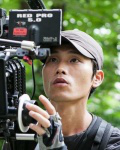

인물코드:  20153482
이름:  이희섭 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9D%B4%ED%9D%AC%EC%84%AD&os=14060063&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  18478425
이름:  이희섭 | 직업:  영화배우, 영화감독 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:(title:"이희섭" AND type:news AND ("이희섭 감독"~10 OR "배우 이희섭"~10))) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18478425
series_id를 매핑해주세요 : 18478425


 36%|███▌      | 32/90 [1:22:59<22:29, 23.27s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------
인물코드:  20152827
이름:  유호정 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9C%A0%ED%98%B8%EC%A0%95&os=14089348&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  685


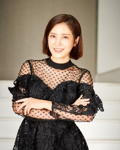

series_id:  685
이름:  유호정 | 직업:  None | 생일:  1969-01-24 | 솔라쿼리:  (content_all:((title:"유호정" -title:"이재룡") AND "기자" AND ("배우 유호정"~10 OR "탤런트 유호정"~10) NOT "크스타뉴스")) | 데뷔:  1991년 드라마 '고개숙인 남자' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/685
series_id를 매핑해주세요 : 


 37%|███▋      | 33/90 [1:23:17<20:43, 21.82s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


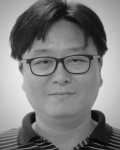

인물코드:  20152437
이름:  유주현 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9C%A0%EC%A3%BC%ED%98%84&os=14033467&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  19188417
이름:  유주현 | 직업:  영화배우,영화감독 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:(title:"유주현" AND type:news AND "배우")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/19188417
series_id를 매핑해주세요 : 19188417


 38%|███▊      | 34/90 [1:23:28<17:15, 18.50s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------
인물코드:  20113335
이름:  이윤석 | 직업:  감독 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9D%B4%EC%9C%A4%EC%84%9D&os=14034574&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1751


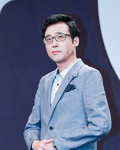

series_id:  1751
이름:  이윤석 | 직업:  MC, 코미디언 | 생일:  1972-02-14 | 솔라쿼리:  (content_all:(title:"이윤석" AND type:news AND ("개그맨 이윤석"~10 OR "MC 이윤석"~10))) | 데뷔:  1993년 MBC 개그콘테스트 금상 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1751
series_id를 매핑해주세요 : 


 39%|███▉      | 35/90 [1:23:31<12:47, 13.96s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20151921
이름:  유신 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9C%A0%EC%8B%A0&os=14039972&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1645


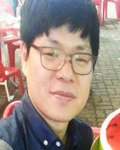

series_id:  1645
이름:  유신 | 직업:  MC, 언론인 | 생일:  1976-04-16 | 솔라쿼리:  (content_all:("MC 유영기"~10 OR "방송인 유영기"~10 OR "언론인 유영기"~10 OR "MC 유신"~10 OR "방송인 유신"~10 OR "언론인 유신"~10)) | 데뷔:  1998년 인터넷방송 '제3세계' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1645
series_id를 매핑해주세요 : 


 40%|████      | 36/90 [1:23:44<12:10, 13.53s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  10062400
이름:  정현우 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A0%95%ED%98%84%EC%9A%B0&os=14036149&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  18508865
이름:  정현우 | 직업:  영화배우,연극배우 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:(title:"정현우" AND type:news AND "배우 정현우"~10)) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18508865
series_id를 매핑해주세요 : 


 41%|████      | 37/90 [1:24:07<14:38, 16.58s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20149984
이름:  유경아 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9C%A0%EA%B2%BD%EC%95%84&os=14175130&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  18822983
이름:  유경아 | 직업:  탤런트 | 생일:  0000-00-00 | 솔라쿼리:  (content_all: (title:"유경아" AND type: news NOT "유경식" NOT "광주시체육회" NOT ("신세계" OR "정유경" OR "정용진" OR "전유경" OR "유경준" OR "골" OR "김유경" OR "광주시" OR "정치부"))) | 데뷔:  1985년 MBC 드라마 '호랑이 선생님' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18822983
series_id를 매핑해주세요 : 


 42%|████▏     | 38/90 [1:24:17<12:39, 14.61s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


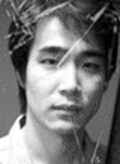

인물코드:  20148439
이름:  김태욱 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%ED%83%9C%EC%9A%B1&os=14076134&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  179


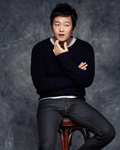

series_id:  179
이름:  김정태 | 직업:  None | 생일:  1973-01-17 | 솔라쿼리:  (content_all:((title :"김정태" -title:"아들" -title:"야꿍이") AND "기자" AND "배우")) | 데뷔:  1999년 영화 '이재수의 난' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/179
series_id를 매핑해주세요 : 


 43%|████▎     | 39/90 [1:24:28<11:17, 13.29s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20148305
이름:  김도훈 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EB%8F%84%ED%9B%88&os=14039011&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  5760545


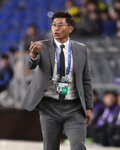

series_id:  5760545
이름:  김도훈 | 직업:  축구감독 | 생일:  1970-07-21 | 솔라쿼리:  (content_all:("김도훈"))-(content_all:("항일투쟁" OR "일용직개인회생")) | 데뷔:  1995년 전북 현대 입단 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/5760545
series_id를 매핑해주세요 : 
[INFO] 매핑 실패!

---------- 셀럽 데이터 ----------
series_id:  18085669
이름:  김도훈 | 직업:  영화배우 | 생일:  1998-09-15 | 솔라쿼리:  (content_all:(title:"김도훈" AND type : news AND "배우")) | 데뷔:  2018년 영화 '게이트' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18085669
series_id를 매핑해주세요 : 


 44%|████▍     | 40/90 [1:24:55<14:38, 17.57s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


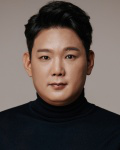

인물코드:  20147703
이름:  김기남 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EA%B8%B0%EB%82%A8&os=162567&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  5213928


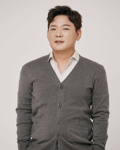

series_id:  5213928
이름:  김기남 | 직업:  배우 | 생일:  1982-07-27 | 솔라쿼리:  (content_all:("배우 김기남"~5 OR "일단뜨겁게청소하라 김기남"~5)) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/5213928
series_id를 매핑해주세요 : 5213928


 46%|████▌     | 41/90 [1:25:09<13:27, 16.49s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------
인물코드:  20065915
이름:  이원희 | 직업:  조감독 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9D%B4%EC%9B%90%ED%9D%AC&os=14040989&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  9664662
이름:  이원희 | 직업:  유도코치 | 생일:  1981-07-19 | 솔라쿼리:  (content_all:("유도선수 이원희"~15 OR "유도 이원희"~15)); | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/9664662
series_id를 매핑해주세요 : 
[INFO] 매핑 실패!

---------- 셀럽 데이터 ----------
series_id:  18940656
이름:  이원희 | 직업:  영화배우 | 생일:  1990-08-25 | 솔라쿼리:  (content_all:(title:"이원희" AND type:news AND "배우" NOT "유도")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18940656
series_id를 매핑해주세요 : 


 47%|████▋     | 42/90 [1:25:26<13:19, 16.67s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20146468
이름:  한진희 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%ED%95%9C%EC%A7%84%ED%9D%AC&os=14155134&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  2040


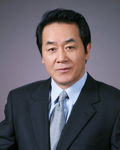

series_id:  2040
이름:  한진희 | 직업:  탤런트, 영화배우 | 생일:  1949-03-14 | 솔라쿼리:  (content_all:("탤런트 한진희"~10 OR "영화배우 한진희"~10 OR "배우 한진희"~10)) | 데뷔:  1969년 TBC 9기 공채 탤런트 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/2040
series_id를 매핑해주세요 : 


 48%|████▊     | 43/90 [1:25:33<10:47, 13.78s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20145459
이름:  강호동 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B0%95%ED%98%B8%EB%8F%99&os=14085249&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  46


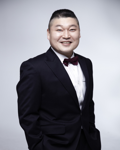

series_id:  46
이름:  강호동 | 직업:  None | 생일:  1970-06-11 | 솔라쿼리:  (content_all:((title:"강호동" -title:"밥심" -title:"더 먹고 가" )AND"기자" NOT"정미애")) | 데뷔:  1993년 MBC 특채 개그맨 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/46
series_id를 매핑해주세요 : 


 49%|████▉     | 44/90 [1:25:41<09:13, 12.04s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20145253
이름:  한지선 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%ED%95%9C%EC%A7%80%EC%84%A0&os=14038574&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  5711079


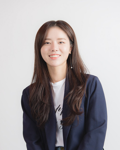

series_id:  5711079
이름:  한지선 | 직업:  탤런트 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:("배우 한지선"~5)) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/5711079
series_id를 매핑해주세요 : 


 50%|█████     | 45/90 [1:25:51<08:35, 11.46s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20145000
이름:  서민정 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%84%9C%EB%AF%BC%EC%A0%95&os=14037314&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  281093


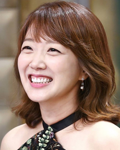

series_id:  281093
이름:  서민정 | 직업:  탤런트, 영화배우 | 생일:  1979-07-11 | 솔라쿼리:  (content_all:("영화배우 서민정"~10 OR "배우 서민정"~10 OR "탤런트 서민정"~10 OR "아이웨이 EMG 서민정"~10 OR "영화배우 서 민정"~10 OR "배우 서 민정"~10 OR "탤런트 서 민정"~10 OR "아이웨이 EMG 서 민정"~10)) | 데뷔:  2000년 NTV '음악천하' VJ | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/281093
series_id를 매핑해주세요 : 


 51%|█████     | 46/90 [1:25:58<07:18,  9.96s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20144850
이름:  서동현 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%84%9C%EB%8F%99%ED%98%84&os=14041788&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  6832904


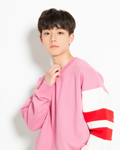

series_id:  6832904
이름:  서동현 | 직업:  탤런트 | 생일:  2003-05-03 | 솔라쿼리:  (content_all:("우리가 만난 기적 서동현"~10 OR "탤런트 서동현"~5)) | 데뷔:  2010년 KBS 드라마 '전우' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/6832904
series_id를 매핑해주세요 : 


 52%|█████▏    | 47/90 [1:26:30<11:56, 16.65s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  10019123
이름:  류지혜 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%A5%98%EC%A7%80%ED%98%9C&os=14042512&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  292


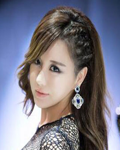

series_id:  292
이름:  류지혜 | 직업:  None | 생일:  1989-10-28 | 솔라쿼리:  (content_all:(title:"류지혜" AND "기자")) | 데뷔:   | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/292
series_id를 매핑해주세요 : 


 53%|█████▎    | 48/90 [1:26:47<11:38, 16.63s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20144603
이름:  강수정 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B0%95%EC%88%98%EC%A0%95&os=14037674&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1120


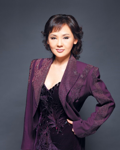

series_id:  1120
이름:  강수정 | 직업:  MC, 전 아나운서 | 생일:  1977-06-29 | 솔라쿼리:  (content_all:("MC 강수정"~10 OR "방송인 강수정"~10 OR "전 아나운서 강수정"~10)) | 데뷔:  2002년 KBS 28기 공채 아나운서 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1120
series_id를 매핑해주세요 : 


 54%|█████▍    | 49/90 [1:26:53<09:11, 13.46s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20144577
이름:  김가연 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EA%B0%80%EC%97%B0&os=14052533&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1105


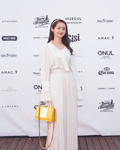

series_id:  1105
이름:  김가연 | 직업:  탤런트, 영화배우 | 생일:  1972-09-09 | 솔라쿼리:  (content_all:((title:"김가연"-title:"임요환") AND "기자" AND ("배우 김가연" ~10 OR "탤런트 김가연"~10))) | 데뷔:  1994년 미스 해태 선 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1105
series_id를 매핑해주세요 : 


 56%|█████▌    | 50/90 [1:27:00<07:45, 11.63s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


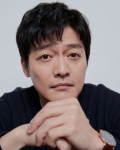

인물코드:  20143883
이름:  권혁 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B6%8C%ED%98%81&os=6440060&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  14784177


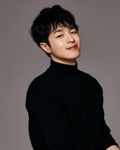

series_id:  14784177
이름:  권혁 | 직업:  탤런트 | 생일:  1989-02-19 | 솔라쿼리:  (content_all:("배우 권혁")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/14784177
series_id를 매핑해주세요 : 
[INFO] 매핑 실패!

---------- 셀럽 데이터 ----------
seires_id:  14786751


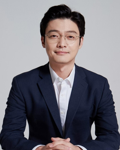

series_id:  14786751
이름:  권혁 | 직업:  영화배우 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:("카이로스 권혁"~10)) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/14786751
series_id를 매핑해주세요 : 14786751


 57%|█████▋    | 51/90 [1:27:56<16:12, 24.93s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------


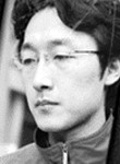

인물코드:  20143440
이름:  권정민 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B6%8C%EC%A0%95%EB%AF%BC&os=14042864&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  19083235
이름:  권정민 | 직업:  영화배우 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:(title:"권정민" AND type:news AND "배우")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/19083235
series_id를 매핑해주세요 : 19083235


 58%|█████▊    | 52/90 [1:28:09<13:29, 21.30s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------
인물코드:  20142442
이름:  백성현 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%B1%EC%84%B1%ED%98%84&os=14075354&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  401


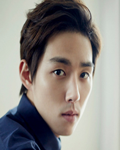

series_id:  401
이름:  백성현 | 직업:  None | 생일:  1989-01-30 | 솔라쿼리:  (content_all:(title:"백성현"AND "기자" ) ) | 데뷔:  1994년 영화 '나는 소망한다 내게 금지된것을' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/401
series_id를 매핑해주세요 : 


 59%|█████▉    | 53/90 [1:28:24<11:59, 19.44s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


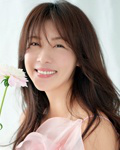

인물코드:  20139691
이름:  하지원 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%ED%95%98%EC%A7%80%EC%9B%90&os=95170&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1035


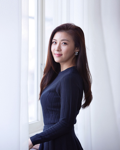

series_id:  1035
이름:  하지원 | 직업:  None | 생일:  1978-06-28 | 솔라쿼리:  (content_all:((title:"하지원" -title:호흡 -title: 한솥밥) AND "기자" NOT 최은희 )) | 데뷔:  1997년 KBS 신세대보고 '수학여행' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1035
series_id를 매핑해주세요 : 1035


 60%|██████    | 54/90 [1:28:37<10:32, 17.57s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------
인물코드:  20138500
이름:  박철 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%95%EC%B2%A0&os=14024295&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  563639


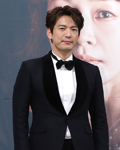

series_id:  563639
이름:  박정철 | 직업:  탤런트, 영화배우 | 생일:  1976-11-05 | 솔라쿼리:  (content_all:(title:"박정철" AND"기자")) | 데뷔:  1997년 kbs 3기 슈퍼탤런트 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/563639
series_id를 매핑해주세요 : 
[INFO] 매핑 실패!

---------- 셀럽 데이터 ----------
series_id:  18823037
이름:  박철 | 직업:  배우 | 생일:  0000-00-00 | 솔라쿼리:  (content_all: (title: "박철") AND type:news AND ("배우" OR "영화" OR "방송" OR "탤런트" OR "라디오" ) NOT "박철상" NOT("박철도" OR "신예" OR "로봇춤" OR "의정부 토크" OR "박철순" OR "스나입스" OR "웨슬리" OR "박철 PD" OR "박철우" OR "비건" OR "BBC" OR "빌리어네어 보이즈클럽")) | 데뷔:  1991년 MBC 드라마 '우리들의 천국' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18823037
series_id를 매핑해주세요 : 


 61%|██████    | 55/90 [1:28:58<10:45, 18.43s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  10029405
이름:  박철 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%95%EC%B2%A0&os=14024295&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  563639


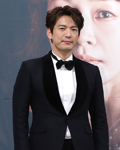

series_id:  563639
이름:  박정철 | 직업:  탤런트, 영화배우 | 생일:  1976-11-05 | 솔라쿼리:  (content_all:(title:"박정철" AND"기자")) | 데뷔:  1997년 kbs 3기 슈퍼탤런트 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/563639
series_id를 매핑해주세요 : 
[INFO] 매핑 실패!

---------- 셀럽 데이터 ----------
series_id:  18823037
이름:  박철 | 직업:  배우 | 생일:  0000-00-00 | 솔라쿼리:  (content_all: (title: "박철") AND type:news AND ("배우" OR "영화" OR "방송" OR "탤런트" OR "라디오" ) NOT "박철상" NOT("박철도" OR "신예" OR "로봇춤" OR "의정부 토크" OR "박철순" OR "스나입스" OR "웨슬리" OR "박철 PD" OR "박철우" OR "비건" OR "BBC" OR "빌리어네어 보이즈클럽")) | 데뷔:  1991년 MBC 드라마 '우리들의 천국' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18823037
series_id를 매핑해주세요 : 


 62%|██████▏   | 56/90 [1:29:07<08:57, 15.80s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20110705
이름:  최현석 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%B5%9C%ED%98%84%EC%84%9D&os=14065123&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  2248


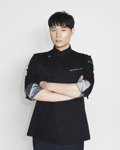

series_id:  2248
이름:  최현석 | 직업:  요리연구가 | 생일:  1972-07-06 | 솔라쿼리:  (content_all:((title:"최현석" -title:최연수) AND type:news AND "최현석 셰프")) | 데뷔:   | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/2248
series_id를 매핑해주세요 : 


 63%|██████▎   | 57/90 [1:29:13<07:03, 12.84s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


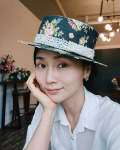

인물코드:  20136131
이름:  조은주 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A1%B0%EC%9D%80%EC%A3%BC&os=9616221&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  18508893
이름:  조은주 | 직업:  영화배우,연극배우 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:(title:"조은주" AND type:news AND "배우")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18508893
series_id를 매핑해주세요 : 18508893


 64%|██████▍   | 58/90 [1:29:23<06:16, 11.77s/it]

[INFO] 매핑 완료!

-------- KOBIS 데이터 ----------
인물코드:  20135511
이름:  김이경 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EC%9D%B4%EA%B2%BD&os=14079619&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  11348314


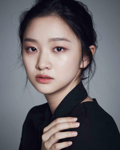

series_id:  11348314
이름:  김이경 | 직업:  탤런트 | 생일:  1997-09-22 | 솔라쿼리:  (content_all:(title:"김이경" AND"기자" )) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/11348314
series_id를 매핑해주세요 : 


 66%|██████▌   | 59/90 [1:29:43<07:29, 14.50s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20124843
이름:  송민 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%86%A1%EB%AF%BC&os=14100903&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1527


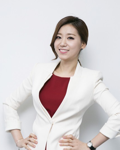

series_id:  1527
이름:  송민 | 직업:  MC, 방송인 | 생일:  1966-07-02 | 솔라쿼리:  (content_all:("MC 송민"~10 OR "방송인 송민"~10 OR "방송인 송민"~10 OR "MC 송영렬"~10 OR "방송인 송영렬"~10 OR "방송인 송영렬"~10)) | 데뷔:   | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1527
series_id를 매핑해주세요 : 


 67%|██████▋   | 60/90 [1:29:52<06:18, 12.63s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20134876
이름:  김민아 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EB%AF%BC%EC%95%84&os=14065879&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  116


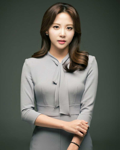

series_id:  116
이름:  김민아 | 직업:  None | 생일:  1983-03-31 | 솔라쿼리:  (content_all:(title:"김민아"AND"기자"AND"아나운서"AND"베이스볼")) | 데뷔:  2007년 MBC ESPN 공채 아나운서 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/116
series_id를 매핑해주세요 : 


 68%|██████▊   | 61/90 [1:30:02<05:42, 11.82s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20134654
이름:  홍진호 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%ED%99%8D%EC%A7%84%ED%98%B8&os=14042173&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  2539


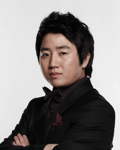

series_id:  2539
이름:  홍진호 | 직업:  방송연예인, 전 프로게이머 | 생일:  1981-10-31 | 솔라쿼리:  (content_all : (title: "홍진호") AND"기자"  AND ("전 프로게이머 홍진호" or "방송인 홍진호")) | 데뷔:  2000년 Game-I 입단 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/2539
series_id를 매핑해주세요 : 


 69%|██████▉   | 62/90 [1:30:07<04:36,  9.89s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20133820
이름:  김윤상 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EC%9C%A4%EC%83%81&os=14067322&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1250


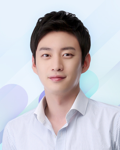

series_id:  1250
이름:  김윤상 | 직업:  아나운서 | 생일:  1988-02-16 | 솔라쿼리:  (content_all:(title:"김윤상" AND"기자")AND("아나운서 김윤상" or "김윤상 아나")) | 데뷔:   | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1250
series_id를 매핑해주세요 : 


 70%|███████   | 63/90 [1:30:20<04:48, 10.68s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20133574
이름:  신지혜 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%8B%A0%EC%A7%80%ED%98%9C&os=129703&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1557


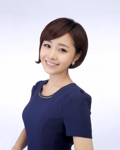

series_id:  1557
이름:  신지혜 | 직업:  아나운서 | 생일:   | 솔라쿼리:  (content_all:(title:"신지혜" AND"기자" AND "신지혜 spotv 아나운서"~5)) | 데뷔:   | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1557
series_id를 매핑해주세요 : 


 71%|███████   | 64/90 [1:30:26<04:02,  9.32s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20133260
이름:  박재연 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%95%EC%9E%AC%EC%97%B0&os=14090255&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  13440269


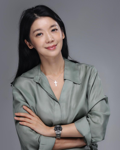

series_id:  13440269
이름:  박재연 | 직업:  작가 | 생일:  0000-00-00 | 솔라쿼리:  (content_all:("상담 전문가 박재연"~50 OR "리플러스인간연구소 박재연"~50 OR "요즘 육아 금쪽같은 내새끼 박재연"~50 OR "엄마의 말하기 연습 박재연"~50)) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/13440269
series_id를 매핑해주세요 : 


 72%|███████▏  | 65/90 [1:30:33<03:38,  8.74s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


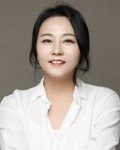

인물코드:  20133172
이름:  신정원 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%8B%A0%EC%A0%95%EC%9B%90&os=162110&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  290306


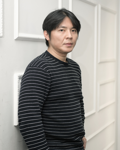

series_id:  290306
이름:  신정원 | 직업:  영화감독 | 생일:  1974-12-20 | 솔라쿼리:  (content_all:(title:"신정원" AND type:news AND "신정원 감독")) | 데뷔:  2004년 영화 '시실리2km' 연출 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/290306
series_id를 매핑해주세요 : 


 73%|███████▎  | 66/90 [1:30:39<03:12,  8.03s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20132854
이름:  최종원 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%B5%9C%EC%A2%85%EC%9B%90&os=14072584&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  12535387
이름:  최종원 | 직업:  탤런트 | 생일:  1950-01-27 | 솔라쿼리:  (content_all:("언터처블 최종원"~50 OR "탤런트 최종원"~10 OR "육룡이나르샤 최종원"~50 NOT "기자삼성" NOT "립스틱")) | 데뷔:  1970년 연극 '콜렉터' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/12535387
series_id를 매핑해주세요 : 


 74%|███████▍  | 67/90 [1:30:46<02:51,  7.45s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


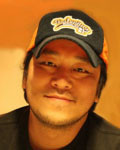

인물코드:  10006323
이름:  김형기 | 직업:  조감독 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%ED%98%95%EA%B8%B0&os=14057021&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  16555081


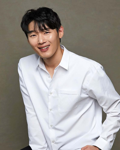

series_id:  16555081
이름:  김도빈 | 직업:  뮤지컬배우 | 생일:  1982-08-05 | 솔라쿼리:  (content_all:(title:"김도빈"AND"기자"AND("뮤지컬"))) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/16555081
series_id를 매핑해주세요 : 


 76%|███████▌  | 68/90 [1:30:53<02:46,  7.56s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20132756
이름:  박은지 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%95%EC%9D%80%EC%A7%80&os=14114601&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1429


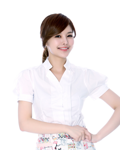

series_id:  1429
이름:  박은지 | 직업:  MC, 전 기상캐스터 | 생일:  1983-05-20 | 솔라쿼리:  (content_all:(title:"박은지" AND type:news AND ("기상캐스터 박은지"~5 OR "방송인 박은지"~10) )) | 데뷔:  2005년 MBC 공채 기상캐스터 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1429
series_id를 매핑해주세요 : 


 77%|███████▋  | 69/90 [1:30:59<02:29,  7.10s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20132494
이름:  박은실 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%95%EC%9D%80%EC%8B%A4&os=14084664&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1427


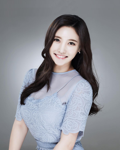

series_id:  1427
이름:  박은실 | 직업:  기상캐스터 | 생일:  1986-12-05 | 솔라쿼리:  (content_all:(title:"박은실" AND type:news AND ("박은실 아나운서"~10 OR "롤러코스터 3") )) | 데뷔:   | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1427
series_id를 매핑해주세요 : 


 78%|███████▊  | 70/90 [1:31:03<02:01,  6.07s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


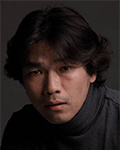

인물코드:  20123333
이름:  박원희 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%95%EC%9B%90%ED%9D%AC&os=14039874&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  12106024


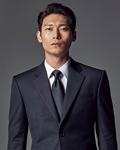

series_id:  12106024
이름:  박훈 | 직업:  연극배우 | 생일:  1981-04-27 | 솔라쿼리:  (content_all:("아무도 모른다 박훈"~50 OR "연극배우 박훈"~20 OR "유도소년 박훈"~50)) | 데뷔:  2007년 뮤지컬 '오! 당신이 잠든 사이' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/12106024
series_id를 매핑해주세요 : 


 79%|███████▉  | 71/90 [1:31:16<02:34,  8.14s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


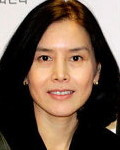

인물코드:  10005234
이름:  김유미 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EC%9C%A0%EB%AF%B8&os=14023700&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  167


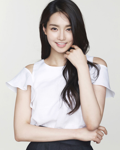

series_id:  167
이름:  김유미 | 직업:  탤런트, 영화배우 | 생일:  1979-10-12 | 솔라쿼리:  (content_all:(title : "김유미"AND "기자" AND"배우 김유미"~5 NOT"미스코리아" NOT"미코")) | 데뷔:  1999년 CF '뉴트로지나' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/167
series_id를 매핑해주세요 : 
[INFO] 매핑 실패!

---------- 셀럽 데이터 ----------
seires_id:  478738


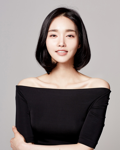

series_id:  478738
이름:  김유미 | 직업:  미스코리아 | 생일:  1990-04-26 | 솔라쿼리:  (content_all:("스타하우스엔터테인먼트 김유미"~10)) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/478738
series_id를 매핑해주세요 : 


 80%|████████  | 72/90 [1:31:30<02:57,  9.86s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


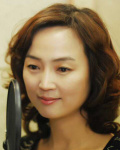

인물코드:  20132071
이름:  김희선 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%ED%9D%AC%EC%84%A0&os=14023190&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  221


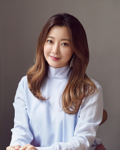

series_id:  221
이름:  김희선 | 직업:  None | 생일:  1977-06-11 | 솔라쿼리:  (content_all:(title:"김희선" AND"기자" AND"배우" )) | 데뷔:  1993년 CF '꽃게랑' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/221
series_id를 매핑해주세요 : 


 81%|████████  | 73/90 [1:31:37<02:31,  8.91s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  10006502
이름:  김훈 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%ED%9B%88&os=14038219&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  16812144


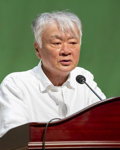

series_id:  16812144
이름:  김훈 | 직업:  소설가, 언론인 | 생일:  1948-05-05 | 솔라쿼리:  (content_all:(title: "김훈" AND"기자")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/16812144
series_id를 매핑해주세요 : 


 82%|████████▏ | 74/90 [1:31:44<02:13,  8.36s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20131691
이름:  김미령 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EB%AF%B8%EB%A0%B9&os=14053564&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  949


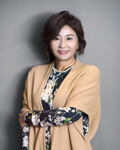

series_id:  949
이름:  진미령 | 직업:  방송인, 가수 | 생일:  1958-04-05 | 솔라쿼리:  (content_all:(title:"진미령" AND "기자"NOT "영웅시대" NOT "한국전쟁" )) | 데뷔:  1976년 앨범 '말해줘요' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/949
series_id를 매핑해주세요 : 


 83%|████████▎ | 75/90 [1:31:52<02:03,  8.20s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20130716
이름:  조민수 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A1%B0%EB%AF%BC%EC%88%98&os=14060691&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  901


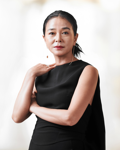

series_id:  901
이름:  조민수 | 직업:  탤런트, 영화배우 | 생일:  1965-01-29 | 솔라쿼리:  (content_all:("영화배우 조민수"~10 OR "배우 조민수"~10 OR "탤런트 조민수"~10 OR "매니지먼트 구 조민수"~10)) | 데뷔:  1986년 KBS 특채 탤런트 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/901
series_id를 매핑해주세요 : 


 84%|████████▍ | 76/90 [1:32:09<02:32, 10.92s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20130707
이름:  조민기 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A1%B0%EB%AF%BC%EA%B8%B0&os=14115428&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  900


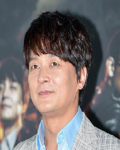

series_id:  900
이름:  조민기 | 직업:  None | 생일:  1965-11-05 | 솔라쿼리:  (content_all:(title:"조민기"  AND "기자" AND "배우 조민기"~10 NOT "NC")) | 데뷔:  1990년 영화 '사의 찬미' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/900
series_id를 매핑해주세요 : 


 86%|████████▌ | 77/90 [1:32:15<02:04,  9.56s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20130211
이름:  김명선 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EB%AA%85%EC%84%A0&os=14038507&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  14094046


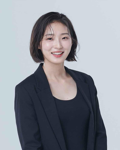

series_id:  14094046
이름:  차희 | 직업:  연극배우 | 생일:  1988-04-17 | 솔라쿼리:  (content_all:("배우 김명선"~50 OR "십시일반 김명선" ~50 OR "연극배우 김명선" ~50)) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/14094046
series_id를 매핑해주세요 : 


 87%|████████▋ | 78/90 [1:32:32<02:21, 11.82s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20110658
이름:  박신영 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EB%B0%95%EC%8B%A0%EC%98%81&os=14035826&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1420


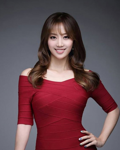

series_id:  1420
이름:  박신영 | 직업:  아나운서 | 생일:  1990-09-14 | 솔라쿼리:  (content_all:(title:"박신영" AND type:news AND "박신영 아나운서"~10)) | 데뷔:   | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1420
series_id를 매핑해주세요 : 


 88%|████████▊ | 79/90 [1:32:39<01:54, 10.38s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


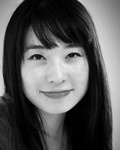

인물코드:  10005294
이름:  김윤정 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EC%9C%A4%EC%A0%95&os=14109233&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  950


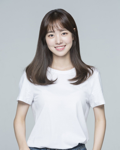

series_id:  950
이름:  진세연 | 직업:  None | 생일:  1994-02-15 | 솔라쿼리:  (content_all:((title:"진세연" -title:"한솥밥" ) AND "기자")) | 데뷔:  2010년 슈어 CF | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/950
series_id를 매핑해주세요 : 


 89%|████████▉ | 80/90 [1:33:00<02:15, 13.57s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20128488
이름:  이다윗 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9D%B4%EB%8B%A4%EC%9C%97&os=14151020&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  478737


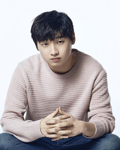

series_id:  478737
이름:  이다윗 | 직업:  영화배우, 탤런트 | 생일:   | 솔라쿼리:  (content_all:("스타하우스엔터테인먼트 이다윗"~10)) | 데뷔:  2003년 KBS 드라마 '무인시대' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/478737
series_id를 매핑해주세요 : 


 90%|█████████ | 81/90 [1:33:16<02:07, 14.21s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20114041
이름:  조한선 | 직업:  감독 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A1%B0%ED%95%9C%EC%84%A0&os=14144718&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  2236


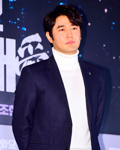

series_id:  2236
이름:  조한선 | 직업:  탤런트, 영화배우 | 생일:  1981-06-17 | 솔라쿼리:  (content_all:(title:"조한선" AND type:news)) | 데뷔:  2001년 OB라거 CF | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/2236
series_id를 매핑해주세요 : 


 91%|█████████ | 82/90 [1:33:19<01:27, 10.93s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  20113286
이름:  김병기 | 직업:  감독 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EB%B3%91%EA%B8%B0&os=14023918&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  11426376
이름:  김병기 | 직업:  탤런트 | 생일:  1948-11-02 | 솔라쿼리:  (content_all:("99억의 여자 김병기"~10 OR "탤런트 김병기"~10 "아이템 김병기"~10)) | 데뷔:  1969년 KBS 8기 공채 탤런트 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/11426376
series_id를 매핑해주세요 : 


 92%|█████████▏| 83/90 [1:33:25<01:06,  9.44s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  10003574
이름:  김경진 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%EA%B2%BD%EC%A7%84&os=14035832&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1289


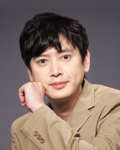

series_id:  1289
이름:  김진 | 직업:  탤런트, 영화배우 | 생일:  1973-08-23 | 솔라쿼리:  (content_all:("영화배우 김경진"~10 OR "배우 김경진"~10 OR "에스피엔터테인먼트 김경진"~10 OR "탤런트 김경진"~10 OR "영화배우 김진"~10 OR "배우 김진"~10 OR "에스피엔터테인먼트 김진"~10 OR "탤런트 김진"~10 OR "루체엔터테인먼트 김진"~10)) | 데뷔:  1994년 좌회전 1집 앨범 '예행연습' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1289
series_id를 매핑해주세요 : 


 93%|█████████▎| 84/90 [1:33:32<00:51,  8.61s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


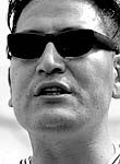

인물코드:  10006084
이름:  김태규 | 직업:  감독 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EA%B9%80%ED%83%9C%EA%B7%9C&os=14024025&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  19188491
이름:  김태규 | 직업:  뮤지컬배우 | 생일:  1992-04-13 | 솔라쿼리:  (content_all:(title:"김태규" AND type:news AND"뮤지컬")) | 데뷔:  2016년 뮤지컬 '삼총사' | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/19188491
series_id를 매핑해주세요 : 


 94%|█████████▍| 85/90 [1:33:37<00:37,  7.53s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  10057620
이름:  이진영 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9D%B4%EC%A7%84%EC%98%81&os=14027108&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  18792664
이름:  이진영 | 직업:  야구코치 | 생일:  1980-06-15 | 솔라쿼리:  (content_all: (title:"이진영") AND type:news AND ("야구" OR "코치" OR "SK" OR "랜더스") ) | 데뷔:  1999년 '쌍방울 레이더스' 입단 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/18792664
series_id를 매핑해주세요 : 


 96%|█████████▌| 86/90 [1:33:39<00:24,  6.03s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


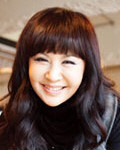

인물코드:  10056159
이름:  이수진 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9D%B4%EC%88%98%EC%A7%84&os=163960&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  1721


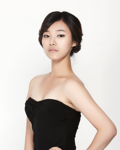

series_id:  1721
이름:  이수진 | 직업:  레이싱모델, 방송인 | 생일:  1985-01-23 | 솔라쿼리:  (content_all:("DcarModel 이수진"~10 OR "방송인 이수진"~10 OR "방송인 이수진"~10 OR "모델 이수진"~10 OR "레이싱모델 이수진"~10 OR "K-1 걸즈 이수진"~10)) | 데뷔:   | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/1721
series_id를 매핑해주세요 : 


 97%|█████████▋| 87/90 [1:33:50<00:21,  7.29s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


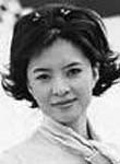

인물코드:  10040546
이름:  신은정 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%8B%A0%EC%9D%80%EC%A0%95&os=14041396&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  557


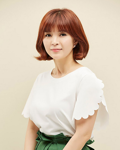

series_id:  557
이름:  신은정 | 직업:  None | 생일:  1974-01-04 | 솔라쿼리:  (content_all:((title:"신은정" -title:"박성웅") AND "기자" AND ("배우 신은정"~20 OR "탤런트 신은정"~20))) | 데뷔:  1998년 SBS 7기 공채 탤런트 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/557
series_id를 매핑해주세요 : 


 98%|█████████▊| 88/90 [1:34:06<00:19,  9.92s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------
인물코드:  10057369
이름:  이종남 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%9D%B4%EC%A2%85%EB%82%A8&os=14034085&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
series_id:  12843045
이름:  이종남 | 직업:  탤런트 | 생일:  1963-04-26 | 솔라쿼리:  (content_all:("탤런트 이종남"~10 OR "화양연화 이종남"~50 OR "비켜라 운명아 이종남"~50 OR "빛나라 은수 이종남"~50 NOT "스포츠닥터스")) | 데뷔:  1983년 KBS 9기 공채 탤런트 | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/12843045
series_id를 매핑해주세요 : 


 99%|█████████▉| 89/90 [1:34:13<00:09,  9.07s/it]

[INFO] 매핑 실패!

-------- KOBIS 데이터 ----------


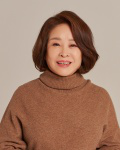

인물코드:  10061304
이름:  전성애 | 직업:  배우 | 네이버:  https://people.search.naver.com/search.naver?where=nexearch&sm=tab_ppn&query=%EC%A0%84%EC%84%B1%EC%95%A0&os=189377&ie=utf8&key=PeopleService
---------- 셀럽 데이터 ----------
seires_id:  15747379


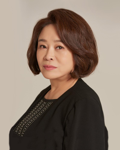

series_id:  15747379
이름:  전성애 | 직업:  영화배우 | 생일:  1956-03-29 | 솔라쿼리:  (content_all:("전성애" NOT"공주" NOT"넥타이를" NOT"콘테스트")) | 데뷔:  None | 도넛:  http://dev.mycelebs.com/donut/Celeb/ShowManageCeleb/15747379
series_id를 매핑해주세요 : 15747379


100%|██████████| 90/90 [1:34:17<00:00, 62.87s/it]

[INFO] 매핑 완료!



In [20]:
number = int(input("매핑할 개체 수 입력 : "))
ex = handMapping(number)

In [17]:
ex

,pk,peopleCd,peopleNm,peopleNmEn,sex,repRoleNm,homepages,filmoNames,movieCd,movieNm,...,birth,country,mapping,SecondUpdate,profileImage,profileKobisImage,profile_naverURL,regist_date,update_date,celeb_idx
0,1010,20066385,이상용,,남자,조감독,None,범죄도시 2|롱 리브 더 킹: 목포 영웅|범죄도시|싱글라이더|악의 연대기|소원|사랑...,"20204548,20198453,20172742,20161723,20149569,2...","범죄도시 2,롱 리브 더 킹: 목포 영웅,범죄도시,싱글라이더,악의 연대기,소원,소원...",...,,None,2,1,,None,https://people.search.naver.com/search.naver?w...,2021-07-14 19:58:48,2021-07-26 07:23:06,


In [21]:
mapping_data, duplicated_list = db_update(ex)
duplicated = pd.DataFrame(duplicated_list)
duplicated.to_excel('duplicated_list_수기매핑.xlsx')

report(mapping_data, total_kobis, data)

! 중복된 celeb_idx 가 있습니다. kobis_people_id: 10005977, celeb_idx: 1242, cd_name: 김창규
! 중복된 celeb_idx 가 있습니다. kobis_people_id: 20159631, celeb_idx: 18727821, cd_name: 최용진
! 중복된 celeb_idx 가 있습니다. kobis_people_id: 20159628, celeb_idx: 18727821, cd_name: 최용진
! 중복된 celeb_idx 가 있습니다. kobis_people_id: 20156084, celeb_idx: 18712597, cd_name: 임성용
! 중복된 celeb_idx 가 있습니다. kobis_people_id: 20154813, celeb_idx: 18989349, cd_name: 박보경
! 중복된 celeb_idx 가 있습니다. kobis_people_id: 20153482, celeb_idx: 18478425, cd_name: 이희섭
! 중복된 celeb_idx 가 있습니다. kobis_people_id: 20152437, celeb_idx: 19188417, cd_name: 유주현
! 중복된 celeb_idx 가 있습니다. kobis_people_id: 20143440, celeb_idx: 19083235, cd_name: 권정민
! 중복된 celeb_idx 가 있습니다. kobis_people_id: 20139691, celeb_idx: 1035, cd_name: 하지원
! 중복된 celeb_idx 가 있습니다. kobis_people_id: 20136131, celeb_idx: 18508893, cd_name: 조은주
! 중복된 celeb_idx 가 있습니다. kobis_people_id: 10061304, celeb_idx: 15747379, cd_name: 전성애
[INFO] 1차 매핑 결과 -> movie_people_connection db insert 완료
[INFO] 수기 매핑 결과 -

ValueError: No engine for filetype: 'excel'

In [22]:
duplicated.to_excel('duplicated_list_수기매핑.xlsx')

In [23]:
report(mapping_data)

* KOBIS 영화 인물 매핑 현황입니다.
- DB명 : kuk > kobis_people_connection
금일 매핑 개수 :  15
누적 매핑 개수 : 3883/12884


In [24]:
newPeople_data

NameError: name 'newPeople_data' is not defined

In [25]:
ex = ex.rename({'peopleCd': 'kobis_people_id', 'peopleNm': 'cd_name'}, axis=1)

mapping_data = ex[ex['celeb_idx'] != '']
newPeople_data = ex[ex['celeb_idx'] == '']

In [26]:
len(newPeople_data)

75

In [27]:
190-75

115

In [28]:
query2 = "select * from maimovie_kr.kobis_people_list where mapping=0"
cnt2 = pd.read_sql(query2, con=conn)

NameError: name 'conn' is not defined

In [29]:
duplicated

,kobis_people_id,celeb_idx,cd_name
0,10005977,1242,김창규
1,20159631,18727821,최용진
2,20159628,18727821,최용진
3,20156084,18712597,임성용
4,20154813,18989349,박보경
5,20153482,18478425,이희섭
6,20152437,19188417,유주현
7,20143440,19083235,권정민
8,20139691,1035,하지원
9,20136131,18508893,조은주


In [30]:
ex

,pk,kobis_people_id,cd_name,peopleNmEn,sex,repRoleNm,homepages,filmoNames,movieCd,movieNm,...,birth,country,mapping,SecondUpdate,profileImage,profileKobisImage,profile_naverURL,regist_date,update_date,celeb_idx
0,111882,20163384,이원일,,남자,배우,None,초승달과 밤배,20030118,초승달과 밤배,...,None,None,2,1,,None,https://people.search.naver.com/search.naver?w...,2021-07-14 20:46:44,2021-07-26 06:55:45,
1,112206,20162975,이대로,,남자,배우,None,전우치,20090077,전우치,...,None,None,2,1,,None,https://people.search.naver.com/search.naver?w...,2021-07-14 20:46:57,2021-07-26 06:55:33,
2,112410,20162727,김진수,,남자,배우,None,고고 70,20080741,고고 70,...,None,None,2,1,,None,https://people.search.naver.com/search.naver?w...,2021-07-14 20:47:03,2021-07-26 06:56:16,
3,113134,20161810,이영자,,여자,배우,None,황무지 5월의 고해|욕창|맹부삼천지교,"20207256,20190465,20190465,20040482","황무지 5월의 고해,욕창,욕창,맹부삼천지교",...,None,None,2,1,,None,https://people.search.naver.com/search.naver?w...,2021-07-14 20:47:23,2021-07-26 06:55:51,
4,113564,10005597,김정운,KIM Jung-woon,남자,배우,None,전야|주유소 습격사건 2|Lucky Strike,"20218168,20090895,20080462","전야,주유소 습격사건 2,Lucky Strike",...,None,None,2,1,https://search.pstatic.net/common?type=a&size=...,None,https://people.search.naver.com/search.naver?w...,2021-07-14 20:47:35,2021-07-26 06:56:06,12504551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,144346,10057620,이진영,YI Jin-young,None,배우,None,무인도의 남과 여,19920036,무인도의 남과 여,...,None,None,2,1,,None,https://people.search.naver.com/search.naver?w...,2021-07-14 21:03:37,2021-07-26 07:23:45,
86,144404,10056159,이수진,,여자,배우,None,바람|바람_감독판|백한번째 프로포즈|캬바레부인|달리는 도시|빠걸|호호전|햄버거 쟈니...,"20090822,20090912,19930016,19900021,19890078,1...","바람,바람_감독판,백한번째 프로포즈,캬바레부인,달리는 도시,빠걸,호호전,햄버거 쟈니...",...,None,None,2,1,https://search.pstatic.net/common?type=a&size=...,None,https://people.search.naver.com/search.naver?w...,2021-07-14 21:03:41,2021-07-26 07:23:20,
87,149558,10040546,신은정,SHIN Eun-cheong,None,배우,None,돌아이 2|돌아이|여우비,"19860049,19850052,20021090","돌아이 2,돌아이,여우비",...,None,None,2,1,https://search.pstatic.net/common?type=a&size=...,None,https://people.search.naver.com/search.naver?w...,2021-07-14 21:07:04,2021-07-26 07:23:27,
88,152095,10057369,이종남,,None,배우,None,동경 아리랑|물목,"19900030,19860056","동경 아리랑,물목",...,None,None,2,1,,None,https://people.search.naver.com/search.naver?w...,2021-07-14 21:08:52,2021-07-26 07:23:32,
